# Sentiment Analysis using LSTM

In the previous notebook, we built a classifier using logistic regression for sentiment analysis of IMDb movie reviews.
<br>In this notebook, we build the classifier using a deep learning technique called recurrent neural network (RNN). 
<br>We implement RNN using long short term memory (lstm) architecture, and PyTorch framework.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import nltk
nltk.download('punkt')
from nltk import word_tokenize

from collections import Counter

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

[nltk_data] Downloading package punkt to /Users/sudhir/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Text Preprocessing

**Importing reviews**

The dataset is discussed in detail in previous notebook. We have two lists, one for training, and other for testing, both consists of 25k reviews, first 12.5k reviews positive and rest 12.5k negative.

In [2]:
reviews_train_raw = []
for line in open('./movie_data/full_train.txt', 'r'):
    reviews_train_raw.append(line.strip())
    
reviews_test_raw = []
for line in open('./movie_data/full_test.txt', 'r'):
    reviews_test_raw.append(line.strip())
    
target = np.array([1 if i < 12500 else 0 for i in range(25000)])   

**make sure to randomized it when training**

**Basic text preprocessing**

Two steps undertaken in this text preprocessing: (1) making all words lowercase, (2) removing everything except words from the reviews

In [3]:
reviews_train_raw[0]

'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'

In [4]:
def text_preprocessing(corpus):
    
    review_preprocessed = []
    
    for review in corpus:
        
        preprocessed = ' '.join([word for word in word_tokenize(review.lower()) if word.isalpha()])
        review_preprocessed.append(preprocessed)
        
    return review_preprocessed

In [5]:
reviews_train = text_preprocessing(reviews_train_raw)
#reviews_test = text_preprocessing(reviews_test_raw)

In [6]:
reviews_train[0]

'bromwell high is a cartoon comedy it ran at the same time as some other programs about school life such as teachers my years in the teaching profession lead me to believe that bromwell high satire is much closer to reality than is teachers the scramble to survive financially the insightful students who can see right through their pathetic teachers pomp the pettiness of the whole situation all remind me of the schools i knew and their students when i saw the episode in which a student repeatedly tried to burn down the school i immediately recalled at high a classic line inspector i here to sack one of your teachers student welcome to bromwell high i expect that many adults of my age think that bromwell high is far fetched what a pity that it is'

**Mapping word to index**

Now, we create a dictionary that maps words into integer indices, with the convention that most frequently occuring words are assigned lower indices.

In [7]:
reviews_combined = ' '.join(reviews_train)              # combining all reviews to get all words
reviews_words = reviews_combined.split()

word_counts = Counter(reviews_words)
sorted_words = word_counts.most_common(len(reviews_words))

vocab_to_index = {w: i+1 for i, (w, c) in enumerate(sorted_words)}

In this mapping, we started our indexing from 1, as keep 0 reserved for the padding purpose. 

**What happens if a new word appears in test set:** What about replacing these words by zero (motivated by padding)

In [8]:
def vocab_to_index_mapping(corpus, vocab_to_index):
    
    reviews_indexed = []
    
    for review in corpus:
        
        indexed = [vocab_to_index[word] for word in review.split()]
        reviews_indexed.append(indexed)
        
    return reviews_indexed

In [9]:
reviews_train_index = vocab_to_index_mapping(reviews_train, vocab_to_index)
#reviews_test_index = vocab_to_index_mapping(reviews_test, vocab_to_index)

**Making all reviews of same length**

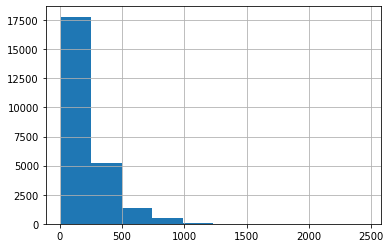

In [10]:
len_reviews = [len(review) for review in reviews_train_index]

pd.Series(len_reviews).hist()
plt.show()

In [11]:
pd.Series(len_reviews).describe()

count    25000.000000
mean       229.809040
std        170.707011
min         10.000000
25%        125.000000
50%        172.000000
75%        279.000000
max       2454.000000
dtype: float64

To deal with both short and long reviews, we will pad or truncate all of our reviews to a specific length.
<br> We define this length by sequence length, which is same as the number of time steps for LSTM layer.

In [12]:
def fixing_reviews_length(reviews_train_index, seq_length):
    
    modified_reviews = np.zeros((len(reviews_train_index), seq_length), dtype = int)
    
    for i, review in enumerate(reviews_train_index):
        
        len_review = len(review)
        
        if len_review <= seq_length:
            pad_zeros = list(np.zeros(seq_length - len_review))
            mod_review = pad_zeros + review
        elif len_review > seq_length:
            mod_review = review[0:seq_length]
            
        modified_reviews[i, :] = np.array(mod_review)
        
    print(modified_reviews.shape)
    return modified_reviews

In [13]:
feature_reviews = fixing_reviews_length(reviews_train_index, 10)

(25000, 10)


# Modelling

First, let's split the data for training and validation

In [14]:
X_train, X_val, y_train, y_val = train_test_split(feature_reviews, target, train_size = 0.8)

**Dataloaders and Batching**

In [15]:
train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
valid_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))

batch_size = 50

train_loader = DataLoader(train_data, shuffle = True, batch_size = batch_size)
valid_loader = DataLoader(valid_data, shuffle = True, batch_size = batch_size)

dataiter = iter(train_loader)
sample_x, sample_y = dataiter.next()

**Model Class**

In [16]:
class SentimentLSTM(nn.Module):
    
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob = 0.4):
        
        super().__init__()
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, dropout = drop_prob, batch_first = True)
        
        self.dropout = nn.Dropout(0.3)
        
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sig = nn.Sigmoid()
        
    def forward(self, x, hidden):
        
        batch_size = x.size(0)
        
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
        
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sig(out)
        
        sig_out = sig_out.view(batch_size, -1)
        sig_out = sig_out[:, -1]
        
        return sig_out, hidden
    
    def init_hidden(self, batch_size):
        
        weight = next(self.parameters()).data
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        
        return hidden 

**Training**

In [17]:
vocab_size = len(vocab_to_index) + 1
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

net = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

lr = 0.001

criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr = lr)

epochs = 5
counter = 0
print_every = 100
clip = 5                  # gradient clipping

net.train()

for e in range(epochs):
    
    h = net.init_hidden(batch_size)
    
    for inputs, labels in train_loader:
        
        counter += 1
        
        h = tuple([each.data for each in h])
        
        net.zero_grad()
        
        inputs = inputs.type(torch.LongTensor)
        output, h = net(inputs, h)
        
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        
        nn.utils.clip_grad_norm(net.parameters(), clip)
        optimizer.step()
        
        if counter % print_every == 0:
            
            val_h = net.init_hidden(batch_size)
            val_losses = []
            net.eval()
            
            for inputs, labels in valid_loader:
                
                val_h = tuple([each.data for each in val_h])
                
                inputs = inputs.type(torch.LongTensor)
                output, val_h = net(inputs, val_h)
                val_loss = criterion(output.squeeze(), labels.float())
                
                val_losses.append(val_loss.item())
                
            net.train()
            print("Epoch: {}/{}...".format(e+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.


Epoch: 1/5... Step: 100... Loss: 0.614757... Val Loss: 0.672089
Epoch: 1/5... Step: 200... Loss: 0.671380... Val Loss: 0.640673
Epoch: 1/5... Step: 300... Loss: 0.615121... Val Loss: 0.635738
Epoch: 1/5... Step: 400... Loss: 0.599936... Val Loss: 0.614623
Epoch: 2/5... Step: 500... Loss: 0.624500... Val Loss: 0.631806
Epoch: 2/5... Step: 600... Loss: 0.557410... Val Loss: 0.619600
Epoch: 2/5... Step: 700... Loss: 0.634037... Val Loss: 0.612871
Epoch: 2/5... Step: 800... Loss: 0.468270... Val Loss: 0.621490
Epoch: 3/5... Step: 900... Loss: 0.360182... Val Loss: 0.688868
Epoch: 3/5... Step: 1000... Loss: 0.344023... Val Loss: 0.715709
Epoch: 3/5... Step: 1100... Loss: 0.408765... Val Loss: 0.670742
Epoch: 3/5... Step: 1200... Loss: 0.473866... Val Loss: 0.673126
Epoch: 4/5... Step: 1300... Loss: 0.157129... Val Loss: 0.848432
Epoch: 4/5... Step: 1400... Loss: 0.298984... Val Loss: 0.793761
Epoch: 4/5... Step: 1500... Loss: 0.256450... Val Loss: 0.858997
Epoch: 4/5... Step: 1600... Loss: 